# Convolutional Pose Machines (for Multi-person) Python Demo Code

## Overview

This ipython notebook demostrates how to detect 2D body joints of multiple people from a single RGB image with Convolutional Pose Machines (CPMs). It is a 2-phase algorithm: (1) person detection, and (2) (multiple) pose estimations. While (2) is the bulk of the paper, you can substitute (1) with any person detector, though our person detector fits CPMs the best so far.

| Input | Result |
| --- | --- |
| ![](figures/frame0181.png) | ![](figures/frame0181_pose.png) |

**Note**: If you are looking for **real-time performance** as demonstrated in CVPR'16, the caffe models below are the ones you need (you can retrieve it by running `testing/get_models.sh`). However, you will need to accelerate the other parts including image processing, data transferring, and result rendering. This code only provides a guild for the whole process.

## Phase 1 - Person Detection

First of all, we need to detect number of people and their individual positions with a person detector trained in a similar way to CPMs (and that's why they fit each other well!) The person detector has exactly the same network structure as CPMs, with difference on number of stages (4) and output channels at the end of each stage (only 1 for the confidence of body center). Here is the goal of this stage:

<img src="figures/frame0181_person.png" width="500">

Let's start with importing stuffs, including ``OpenCV`` and the most important, ``caffe``. The ``config_reader`` will read the file `testing/python/config`, which records important parameters of the trained models.

In [1]:
import cv2 as cv 
import numpy as np
import scipy
import PIL.Image
import math
import caffe
import time
from config_reader import config_reader
import util
import copy

Load an image and display it. Note that the CPM models are trained with BGR images instead of RGB ones (due to OpenCV), so it is important you feed images into CPMs in correct channel order. In the following ``PIL.Image.open`` is reading the image in RGB order, so you see the wrong color with the function ``showBGRImage``:

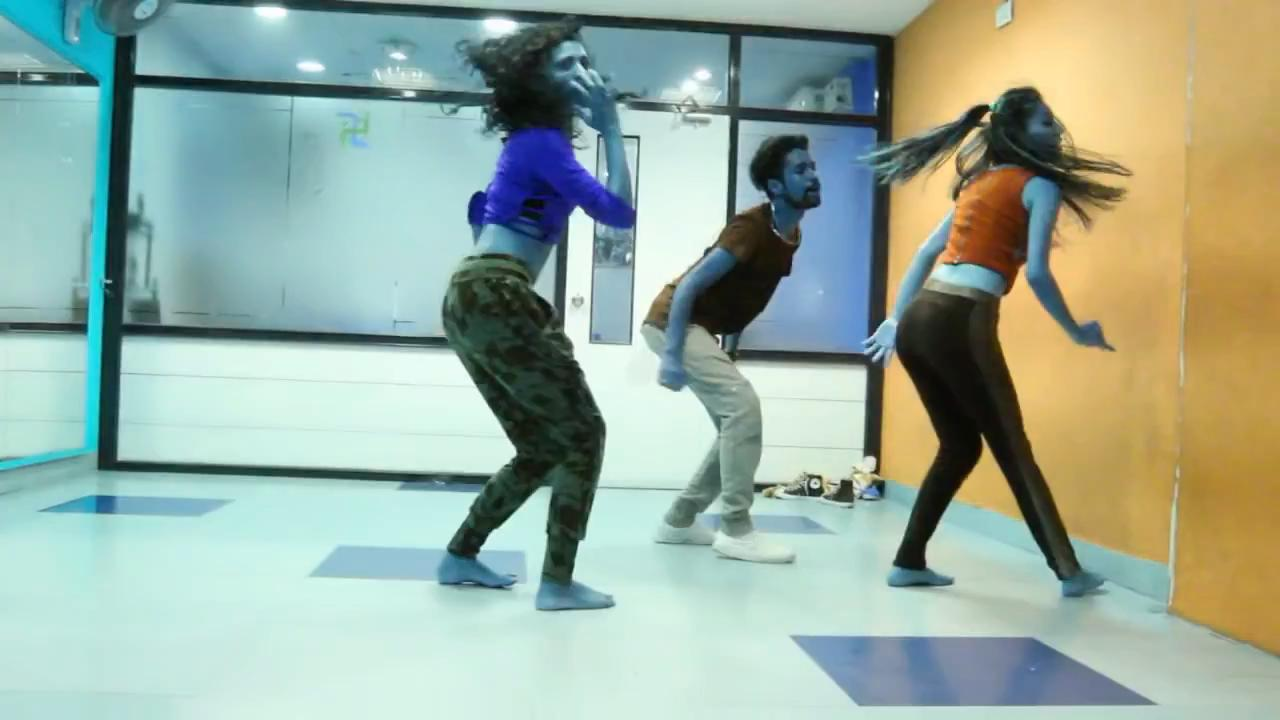

In [2]:
test_image = '../sample_image/frame0181.png'
img = np.float32(PIL.Image.open(test_image))
util.showBGRimage(img)

This time we use ``OpenCV`` to open it and now we see correct color.

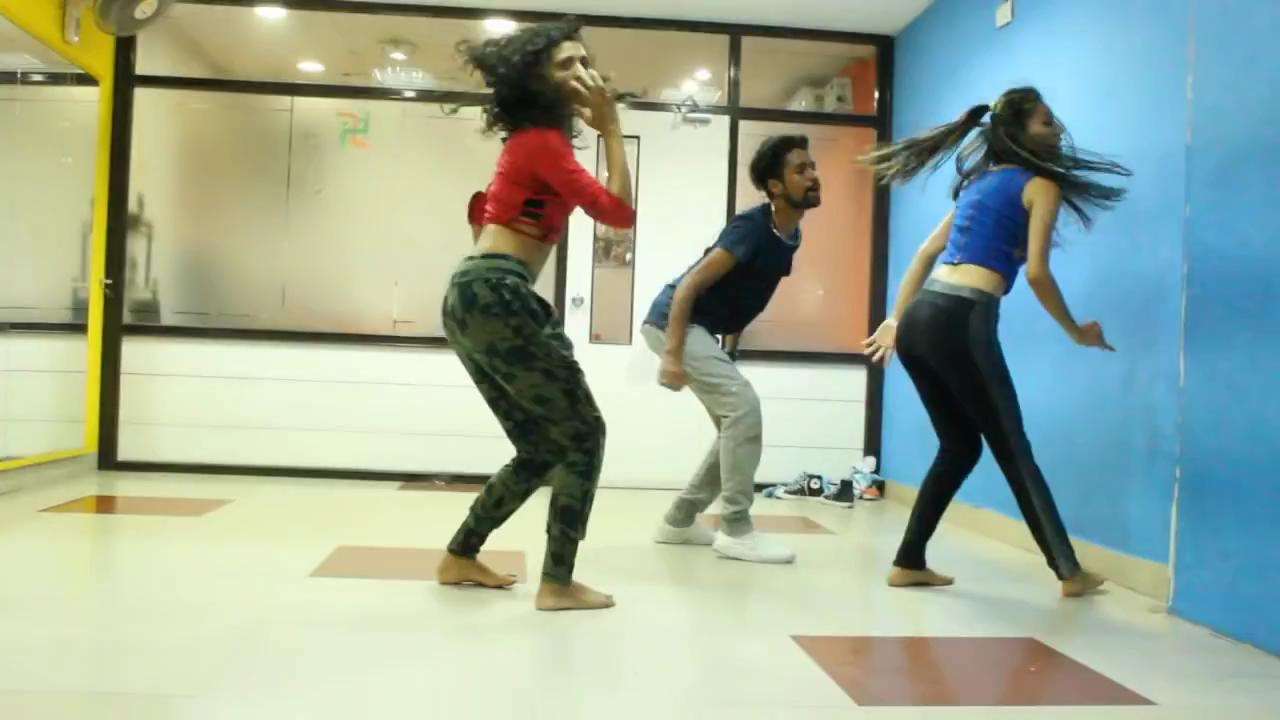

In [3]:
oriImg = cv.imread(test_image) # B,G,R order
util.showBGRimage(oriImg)

Now we are going to **rescale** the image to a size such that if we crop a square on the image on a proper location, the square area can nicely fit a person inside it. Since we have no clue about the size of people relative to the image, ideally we should search over a wide range of scales and combine the result of them, as demonstrated in the matlab code. Here, considering the scaling augmentation we used during the training (so that the model can recognize person/pose in a certain range of scales), and for faster speed, here we only show how to do inference with **one** scale, assuming the height of people are not exceeding the height of the image but also not too small. That is, rescale the height of the image to the square size used during training, which is recorded in ``config``.

In [4]:
param, model = config_reader()
boxsize = model['boxsize']
npart = model['np']
scale = boxsize/(oriImg.shape[0] * 1.0)
imageToTest = cv.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv.INTER_CUBIC)

And because the network is downsizing the input image by 8x, we need to pad the image (on the right and bottom) to make its width and height be multiplies of 8. 

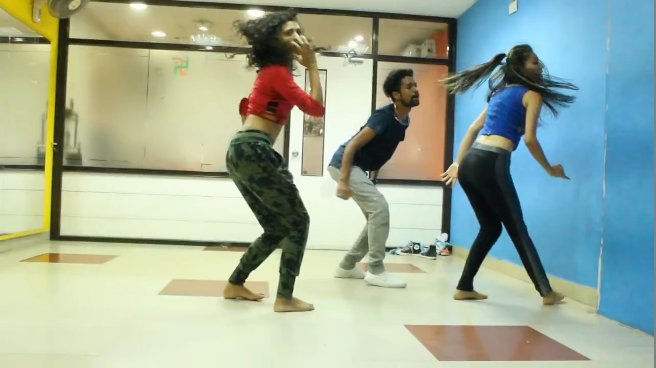

((368, 656, 3), [0, 0, 0, 2])


In [5]:
imageToTest_padded, pad = util.padRightDownCorner(imageToTest)
util.showBGRimage(imageToTest_padded, 'png')
print(imageToTest_padded.shape, pad)

Now it's caffe time. Here's the model and deploy file we are using for person detection:

In [6]:
print(model['deployFile_person'])
print(model['caffemodel_person'])

../../model/_trained_person_MPI/pose_deploy_copy_4sg_resize.prototxt
../../model/_trained_person_MPI/pose_iter_70000.caffemodel


Load the net, reshape the input blob to what we have determined, and then reshape the whole network:

In [7]:
if param['use_gpu']: 
    caffe.set_mode_gpu()
else:
    caffe.set_mode_cpu()
caffe.set_device(param['GPUdeviceNumber']) # set to your device!
person_net = caffe.Net(model['deployFile_person'], model['caffemodel_person'], caffe.TEST)
person_net.blobs['image'].reshape(*(1, 3, imageToTest_padded.shape[0], imageToTest_padded.shape[1]))
person_net.reshape()
person_net.forward(); # dry run to avoid GPU synchronization later in caffe

Now we can fill the data blob with normalized (to range [-0.5, 0.5]) and evaluate the network. On a Titan X, the person took about X ms. You see the output is a blob with 1 channel and spatially 8 times smaller than original input image. It contains 5 peaks, each one corresponds to a body center.

Person net took 76.34 ms.
['Mconv7_stage4']
(1, 1, 46, 82)


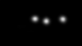

In [8]:
person_net.blobs['image'].data[...] = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,2,0,1))/256 - 0.5;
start_time = time.time()
output_blobs = person_net.forward()
print('Person net took %.2f ms.' % (1000 * (time.time() - start_time)))
print(output_blobs.keys())
print(output_blobs[output_blobs.keys()[0]].shape)
person_map = np.squeeze(person_net.blobs[output_blobs.keys()[0]].data)
util.showmap(person_map * 256)

To get the center position, we have to rescale the output 8x back and find local maximums above certain threshold:

(array([280, 503, 369]), array([150, 152, 169]))


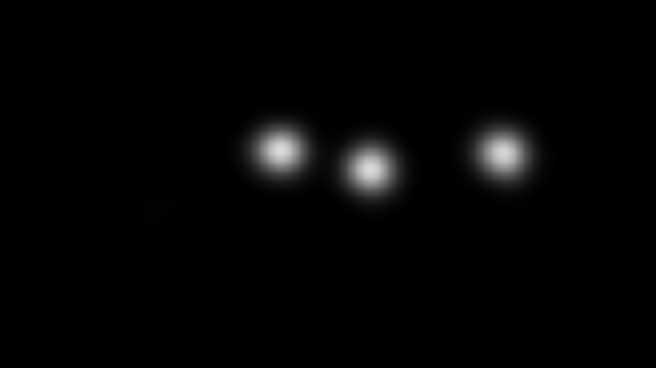

In [9]:
person_map_resized = cv.resize(person_map, (0,0), fx=8, fy=8, interpolation=cv.INTER_CUBIC)
data_max = scipy.ndimage.filters.maximum_filter(person_map_resized, 3)
maxima = (person_map_resized == data_max)
diff = (data_max > 0.5)
maxima[diff == 0] = 0
x = np.nonzero(maxima)[1]
y = np.nonzero(maxima)[0]

print(x, y)
util.showmap(person_map_resized * 256)

More visualization to verify:

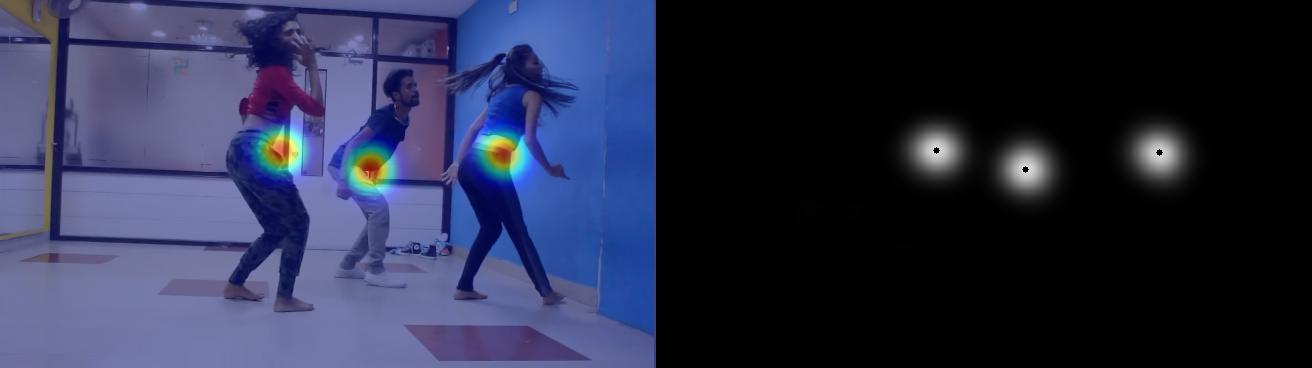

In [10]:
person_map_to_plot_1 = util.colorize(person_map_resized) * 0.5 + imageToTest_padded * 0.5
person_map_to_plot_2 = person_map_resized * 255
for x_c, y_c in zip(x, y):
    cv.circle(person_map_to_plot_2, (x_c, y_c), 3, (0,0,255), -1)
util.showBGRimage(np.concatenate((person_map_to_plot_1, np.tile(person_map_to_plot_2[:,:,np.newaxis], (1,1,3))), axis=1))

## Phase 2: Pose Estimations with CPMs

With the center positions, we can now apply CPMs to do individual pose estimations by cropping regions of interest on the image.

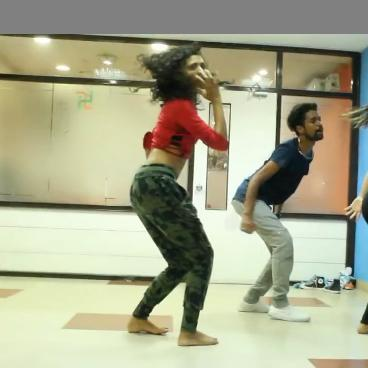

In [11]:
num_people = x.size
person_image = np.ones((model['boxsize'], model['boxsize'], 3, num_people)) * 128
for p in range(num_people):
    for x_p in range(model['boxsize']):
        for y_p in range(model['boxsize']):
            x_i = x_p - model['boxsize']/2 + x[p]
            y_i = y_p - model['boxsize']/2 + y[p]
            if x_i >= 0 and x_i < imageToTest.shape[1] and y_i >= 0 and y_i < imageToTest.shape[0]:
                person_image[y_p, x_p, :, p] = imageToTest[y_i, x_i, :]
# show one of them for inspection
util.showBGRimage(person_image[:,:,:,0])

As decribed in the paper, during the training we used a Gaussian peak centered at body to eliminate part responses on the people nearby. We explictly produce it and put it at the 4th channel of each cropped region for the input of CPM.

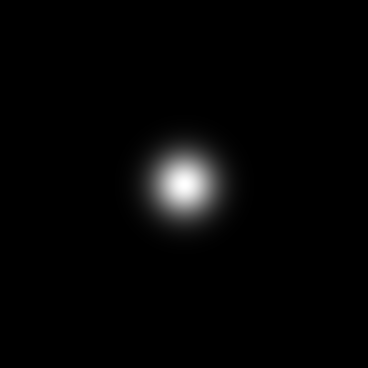

In [12]:
gaussian_map = np.zeros((model['boxsize'], model['boxsize']))
for x_p in range(model['boxsize']):
    for y_p in range(model['boxsize']):
        dist_sq = (x_p - model['boxsize']/2) * (x_p - model['boxsize']/2) + \
                  (y_p - model['boxsize']/2) * (y_p - model['boxsize']/2)
        exponent = dist_sq / 2.0 / model['sigma'] / model['sigma']
        gaussian_map[y_p, x_p] = math.exp(-exponent)
util.showmap(gaussian_map * 256)

We now run CPM for each person (region of interest) individually. Each of evaluation takes 55~65 ms on a Titan X. Together with the time spent on person detection (phase 1), we can get roughly 7~9 fps here for 1 person, **if you make all the other parts fast enough**. Of course you can run only one evaluation for all the people with non-singleton batch size for better performance, as long as you have enough GPU memory. In this way you can run faster for multiple people.

In [13]:
pose_net = caffe.Net(model['deployFile'], model['caffemodel'], caffe.TEST)
pose_net.forward() # dry run to avoid GPU synchronization later in caffe
output_blobs_array = [dict() for dummy in range(num_people)]
for p in range(num_people):
    input_4ch = np.ones((model['boxsize'], model['boxsize'], 4))
    input_4ch[:,:,0:3] = person_image[:,:,:,p]/256.0 - 0.5 # normalize to [-0.5, 0.5]
    input_4ch[:,:,3] = gaussian_map
    pose_net.blobs['data'].data[...] = np.transpose(np.float32(input_4ch[:,:,:,np.newaxis]), (3,2,0,1))
    start_time = time.time()
    output_blobs_array[p] = copy.deepcopy(pose_net.forward()['Mconv7_stage6'])
    print('For person %d, pose net took %.2f ms.' % (p, 1000 * (time.time() - start_time)))

For person 0, pose net took 62.63 ms.
For person 1, pose net took 60.49 ms.
For person 2, pose net took 56.93 ms.


Note that now the output for each person is a number (15) of confidence maps, one for each body part plus a background channel. Here's some visualization:

Person 0


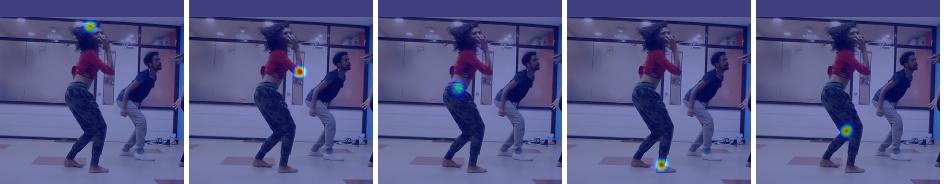

Person 1


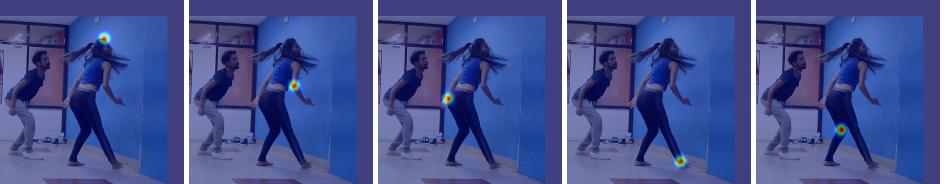

Person 2


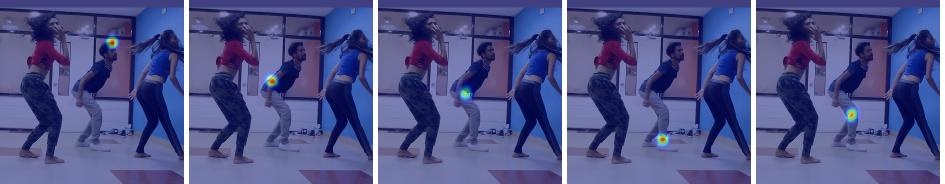

In [14]:
for p in range(num_people):
    print('Person %d' % p)
    down_scaled_image = cv.resize(person_image[:,:,:,p], (0,0), fx=0.5, fy=0.5, interpolation=cv.INTER_CUBIC)
    canvas = np.empty(shape=(model['boxsize']/2, 0, 3))
    for part in [0,3,7,10,12]: # sample 5 body parts: [head, right elbow, left wrist, right ankle, left knee]
        part_map = output_blobs_array[p][0,part,:,:]
        part_map_resized = cv.resize(part_map, (0,0), fx=4, fy=4, interpolation=cv.INTER_CUBIC) #only for displaying
        part_map_color = util.colorize(part_map_resized)
        part_map_color_blend = part_map_color * 0.5 + down_scaled_image * 0.5
        canvas = np.concatenate((canvas, part_map_color_blend), axis=1)
        canvas = np.concatenate((canvas, 255 * np.ones((model['boxsize']/2, 5, 3))), axis=1)
    util.showBGRimage(canvas)

To get predictions, similarly we have to upscale the confidence maps by 8x, and pick the strongest peak as prediction.

In [15]:
prediction = np.zeros((14, 2, num_people))
for p in range(num_people):
    for part in range(14):
        part_map = output_blobs_array[p][0, part, :, :]
        part_map_resized = cv.resize(part_map, (0,0), fx=8, fy=8, interpolation=cv.INTER_CUBIC)
        prediction[part,:,p] = np.unravel_index(part_map_resized.argmax(), part_map_resized.shape)
    # mapped back on full image
    prediction[:,0,p] = prediction[:,0,p] - (model['boxsize']/2) + y[p]
    prediction[:,1,p] = prediction[:,1,p] - (model['boxsize']/2) + x[p]

Finally we visualize the landmark positions, and the limbs from the prediction by plotting colored ellipses. See L/R arms and legs are distinguished!

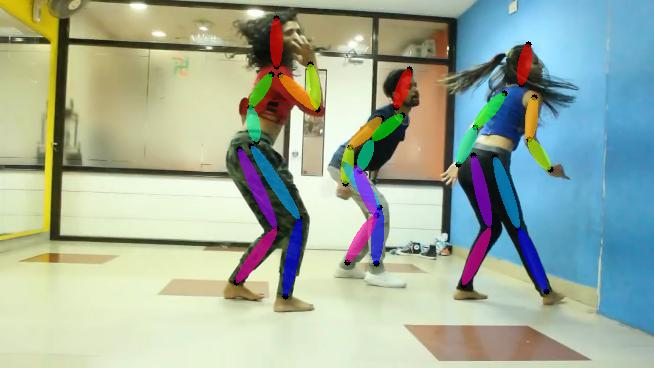

In [16]:
limbs = model['limbs']
stickwidth = 6
colors = [[0, 0, 255], [0, 170, 255], [0, 255, 170], [0, 255, 0], [170, 255, 0],
[255, 170, 0], [255, 0, 0], [255, 0, 170], [170, 0, 255]] # note BGR ...
canvas = imageToTest.copy()
for p in range(num_people):
    for part in range(model['np']):
        cv.circle(canvas, (int(prediction[part, 1, p]), int(prediction[part, 0, p])), 3, (0, 0, 0), -1)
    for l in range(limbs.shape[0]):
        cur_canvas = canvas.copy()
        X = prediction[limbs[l,:]-1, 0, p]
        Y = prediction[limbs[l,:]-1, 1, p]
        mX = np.mean(X)
        mY = np.mean(Y)
        length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
        angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
        polygon = cv.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
        cv.fillConvexPoly(cur_canvas, polygon, colors[l])
        canvas = canvas * 0.4 + cur_canvas * 0.6 # for transparency
util.showBGRimage(canvas)